In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet201

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size
import keras.backend as K

Using TensorFlow backend.


# DenseNet201 Fine Tuning

In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='DenseNet', test_size=0.1)

In [3]:
model_name = 'DenseNet201-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3
base_model = DenseNet201(weights='imagenet', include_top=False,
                         input_shape=(img_rows, img_cols, img_channel))

for layer in base_model.layers:
    #layer.trainable = False
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
# or if we want to set the first 20 layers of the network to be non-trainable
#for layer in model.layers[:20]:
#    layer.trainable=False
#for layer in model.layers[20:]:
#    layer.trainable=True

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.5)(x)
x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
x = Dense(1024,activation='relu')(x) #dense layer 2
x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
#x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [4]:
from keras.callbacks import ReduceLROnPlateau

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-4,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

model_path = './saved_models/DensetNet_0509007.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001, cooldown=2)

earlystop = EarlyStopping(monitor='val_acc', patience=16, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/400
167/168 [============================>.] - ETA: 0s - loss: 0.8646 - acc: 0.7202
Epoch 00001: val_acc improved from -inf to 0.77592, saving model to ./saved_models/DensetNet_0509006.h5
168/168 [==============================] - 217s 1s/step - loss: 0.8628 - acc: 0.7207 - val_loss: 0.6749 - val_acc: 0.7759
Epoch 2/400
167/168 [============================>.] - ETA: 0s - loss: 0.3999 - acc: 0.8666
Epoch 00002: val_acc improved from 0.77592 to 0.84281, saving model to ./saved_models/DensetNet_0509006.h5
168/168 [==============================] - 38s 229ms/step - loss: 0.4012 - acc: 0.8655 - val_loss: 0.5113 - val_acc: 0.8428
Epoch 3/400
167/168 [============================>.] - ETA: 0s - loss: 0.3323 - acc: 0.8911
Epoch 00003: val_acc improved from 0.84281 to 0.86957, saving model to ./saved_models/DensetNet_0509006.h5
168/168 [==============================] - 37s 222ms/step - loss: 0.3345 - acc: 0.8906 - val_loss: 0.4286 - val_acc: 0.8696
Epoch 4/400
167/168 [===============

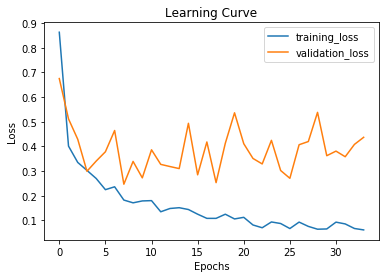

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

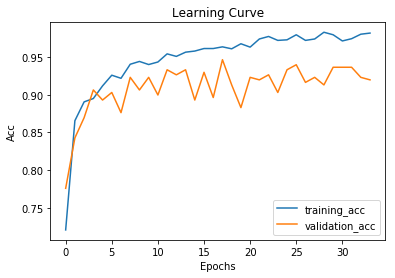

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [9]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='DenseNet')

model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')

299/299 [==============================] - 12s 40ms/step
Validation loss: 0.2528247870211871
Validation accuracy: 0.9464882943143813


In [10]:
y_test_pred_df.to_csv('DensetNet_0509007.csv'.format(model_name), index=False)